In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt
!{sys.executable} -m pip install pyarrow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import boto3
import datetime
import json
import math 
import matplotlib.pyplot as plt   
from matplotlib import pyplot
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.deserializers import StringDeserializer
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import LibSVMSerializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import seaborn  
from sklearn.datasets import dump_svmlight_file   
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
import sys
import time
from xgboost import XGBClassifier

In [3]:
def date_s():
  return datetime.datetime.now().isoformat().replace('.','-').replace(':','-')[:-7] +'Z' 
print('Start at', date_s())

Start at 2020-12-03T13-18-01Z


In [4]:
%%time

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 227 ms, sys: 3.74 ms, total: 231 ms
Wall time: 2.28 s


In [5]:
%%time
filename='from_databrew.parquet.snappy' 
s3 = boto3.resource('s3', region_name=region)

#s3.Bucket(bucket).download_file(
# 'normalize-3-snappy-parquet/normalize-3_02Dec2020_1606903905135/normalize-3_02Dec2020_1606903905135_part00000.parquet.snappy',
#    filename)
table = pq.read_table(filename)
df = table.to_pandas()    
    
print('Length', len(df))

Length 6362620
CPU times: user 1.09 s, sys: 643 ms, total: 1.73 s
Wall time: 1.65 s


In [6]:
fraction_to_retain = 1.0
df = df.sample(frac=fraction_to_retain, replace=True, random_state=1)
if fraction_to_retain < 1.0:
    print('Length after downsampling', len(df))
df

,isFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_nml,oldBalanceOrigin_nml,newBalanceOrigin_nml,oldBalanceDestination_nml,newBalanceDestination_nml
4322341,0,20.0,0,0,0,1,0,-0.229409,-0.287947,-0.292442,-0.323814,-0.333411
4686059,0,19.0,0,0,0,1,0,-0.288739,-0.288716,-0.292442,-0.323814,-0.333411
3937352,0,22.0,0,1,0,0,0,-0.085726,-0.288716,-0.292442,2.193641,2.030517
491263,0,19.0,0,1,0,0,0,-0.064778,-0.288716,-0.292442,0.229449,0.216756
5030793,0,18.0,0,1,0,0,0,-0.037904,-0.199619,-0.258119,1.646407,1.532095
...,...,...,...,...,...,...,...,...,...,...,...,...
1858543,0,20.0,1,0,0,0,0,0.021337,1.802330,1.838917,-0.167669,-0.241412
2581057,0,15.0,0,0,0,1,0,-0.255680,-0.288547,-0.292442,-0.323814,-0.333411
4724952,0,20.0,0,0,0,1,0,-0.292877,-0.256813,-0.261957,-0.323814,-0.333411
923095,0,19.0,0,1,0,0,0,0.059901,-0.288716,-0.292442,-0.222012,-0.180429


In [7]:
target_col='isFraud'

# Data visualization and analysis

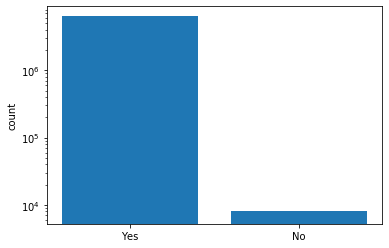

In [8]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

def plot_positive_negative_counts(df, target_col):
    val_counts=df['isFraud'].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale='log')
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,'isFraud')

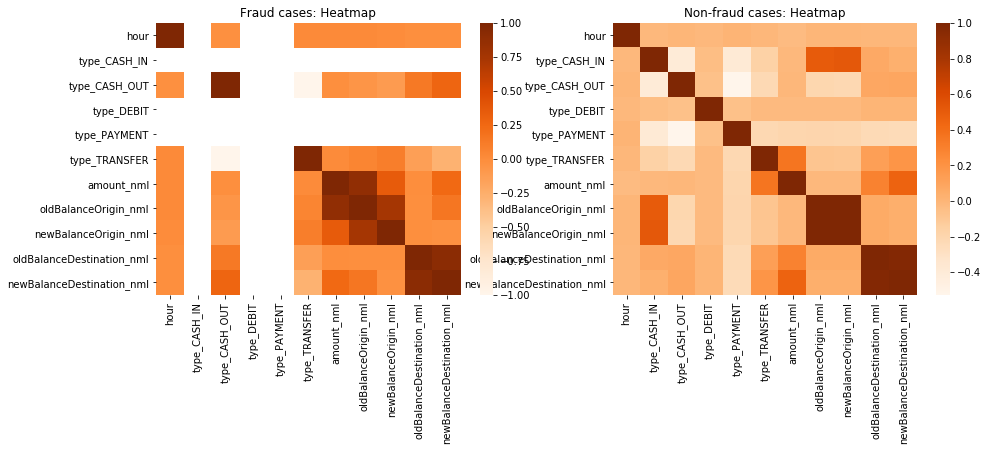

In [9]:
fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl = 'Fraud' if  fraud_cases else 'Non-fraud'
    axes[1 - int(fraud_cases)].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'isFraud == {fraud_cases}').drop(['isFraud'], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

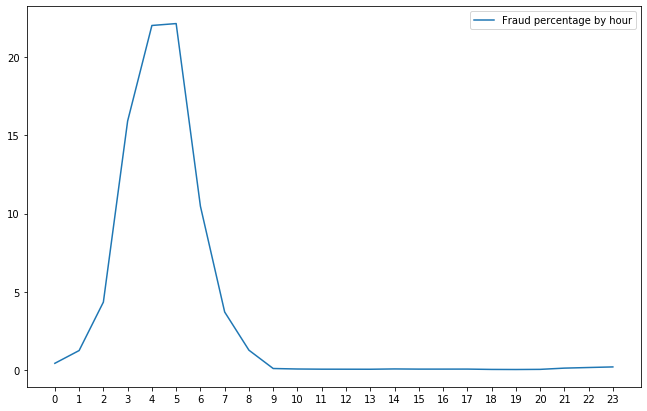

In [10]:
HOURS_IN_DAY  =24

frauds_by_hour = []
non_frauds_by_hour = []
hourwise_items = []
for hour in range(HOURS_IN_DAY):
    non_fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 0)]
    non_fraud_sum_in_hour = len(non_fraud_in_hour)
    fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 1)]
    fraud_sum_in_hour = len(fraud_in_hour)
    non_frauds_by_hour.append(non_fraud_sum_in_hour)
    frauds_by_hour.append(fraud_sum_in_hour)
    hourwise_items.append(non_fraud_sum_in_hour+fraud_sum_in_hour)

figure, axis = plt.subplots(figsize=(11, 7))
 
fr_non_fraud = axis.plot(np.multiply(np.divide(frauds_by_hour,hourwise_items), 100), label='Fraud percentage by hour')
plt.xticks(range(24))
legend = axis.legend(loc='upper right' )

# Data prep: Add non-peak hours field

In [11]:
peak_hours_mask = (df['hour'] >=2) & (df['hour'] <= 6 )
df[peak_hours_mask]['peakHours'] = 1
nonpeak_hours_mask = (df['hour'] <2) | (df['hour'] > 6 )
df[nonpeak_hours_mask]['peakHours'] = 0

conditions = [
    (df['hour'] < 2) | (df['hour'] > 6),
    (df['hour'] >=2) & (df['hour'] <= 6) ]

values = [0,1]

df['peakHours'] = np.select(conditions, values)

del df['hour']
 

# Start Sagemaker (non-local) train/deploy/predict sequence 

## Prepare training, validation, and test sets

In [12]:
%%time
len_ = len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.5 * len_), int(0.7 * len_)])

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset = d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

Length of datasets: [('train', 3181310), ('validation', 1272524), ('test', 1908786)]
CPU times: user 4min, sys: 1.87 s, total: 4min 2s
Wall time: 4min 4s


In [13]:
s3 = boto3.resource('s3', region_name=region)#TODO Remove

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

In [14]:
def s3_path(subset):
  return sagemaker.TrainingInput(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

## Train, including hyperparameter tuning

In [21]:
container = get_image_uri(region, 'xgboost','1.0-1')

xgb = Estimator(container, 
                role,  
                base_job_name='fraud-detection-job',
                instance_count=1, 
                instance_type='ml.c5.xlarge',
                output_path=f's3://{bucket}/{prefix}/output', sagemaker_session=session,
                #train_use_spot_instances=True,
                #train_max_wait=60*60,
                #train_max_run=60*60,    
                #checkpoint_s3_uri=f's3://{bucket}/{prefix}/checkpoint',
)


num_positive, num_negative=count_positive_and_negative(train_data)
scale_pos_weight= math.sqrt(1 if not num_positive else num_negative / num_positive )

print(f'num_positive: {num_positive}, num_negative: {num_negative}, scale_pos_weight {scale_pos_weight:.1f}')

xgb.set_hyperparameters(eval_metric='aucpr',
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=80)
xgb.hyperparameters()

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


1
num_positive: 4011, num_negative: 3177299, scale_pos_weight 28.1


{'eval_metric': 'aucpr',
 'objective': 'binary:logistic',
 'scale_pos_weight': 28.145094555610456,
 'num_round': 80}

In [27]:
%%time
print('Start training at', date_s())
hypertune = True
if not hypertune:
    xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
    training_job_name = xgb._current_job_name
else:
    hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(5, 7),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 4)}


    objective_metric_name = 'validation:f1'

    tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, 
                            base_tuning_job_name='hypertune',
                            max_parallel_jobs=10)
    
    print('Starting hypertuning job')
    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, 
              include_cls_metadata=False, wait=False)
    print('Started hypertuning job', tuner.latest_tuning_job.job_name)

    counter = 0
    status = 'InProgress'
    while status == 'InProgress':
        tuning_job_result=boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
           HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)
        counter += 0.5
        time.sleep(30)   
        status = tuning_job_result['HyperParameterTuningJobStatus']
        print(f'{counter} min., {status};', end=' ')
        
    if 'BestTrainingJob' in tuning_job_result:
       training_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']
    else:
       pprint.pprint(tuning_job_result)
       raise Exception('No best job identified')

Start training at 2020-12-03T13-44-50Z
Starting hypertuning job
Started hypertuning job hypertune-201203-1344
0.5 min., InProgress; 1.0 min., InProgress; 1.5 min., InProgress; 2.0 min., InProgress; 2.5 min., InProgress; 3.0 min., InProgress; 3.5 min., InProgress; 4.0 min., InProgress; 4.5 min., InProgress; 5.0 min., InProgress; 5.5 min., InProgress; 6.0 min., InProgress; 6.5 min., InProgress; 7.0 min., InProgress; 7.5 min., InProgress; 8.0 min., InProgress; 8.5 min., InProgress; 9.0 min., InProgress; 9.5 min., InProgress; 10.0 min., InProgress; 10.5 min., InProgress; 11.0 min., InProgress; 11.5 min., InProgress; 12.0 min., InProgress; 12.5 min., InProgress; 13.0 min., InProgress; 13.5 min., InProgress; 14.0 min., InProgress; 14.5 min., InProgress; 15.0 min., InProgress; 15.5 min., InProgress; 16.0 min., InProgress; 16.5 min., InProgress; 17.0 min., InProgress; 17.5 min., InProgress; 18.0 min., InProgress; 18.5 min., InProgress; 19.0 min., InProgress; 19.5 min., InProgress; 20.0 min., I

## Deploy

In [28]:
%%time
serializer = LibSVMSerializer()
deserializer = StringDeserializer() 
deserializer.CONTENT_TYPE = "text/libsvm"

model = xgb.create_model()

container_def = model.prepare_container_def(instance_type='ml.m4.xlarge')

model_name = 'fraud-' +date_s()
print('model_name', model_name)
 
endpoint_name = 'fraud-detection-endpoint'
 
def deploy_on_new_endpoint():
      print('Deploy on new endpoint')
      _ = xgb.deploy(endpoint_name=endpoint_name, model_name=model_name,
                                 initial_instance_count=1, instance_type='ml.m5.xlarge', 
                                 accelerator_type='ml.eia2.medium')
      
  
    
def deploy_on_existing_endpoint():
        print('Deploy on existing endpoint') 
        session.create_model(model_name, role, container_def)
        
        endpoint_config_name = session.create_endpoint_config(name=model_name+date_s(),
                                                      model_name=model_name,
                                                      initial_instance_count=1,
                                                      instance_type='ml.m5.xlarge',
                                                      accelerator_type='ml.eia2.medium')
        
        client = boto3.client('sagemaker')
        updated_endpoint=client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
   
 
while True:
  try:
     deploy_on_existing_endpoint()
     break
  except Exception as e:
      if 'Cannot update in-progress endpoint' in str(e):
        print('Cannot update in-progress endpoint')
        time.sleep(30)
        continue
      elif 'Could not find endpoint' in str(e):
        print('Could not find endpoint')
        deploy_on_new_endpoint()
        break;
      else:
        print("Exception", e)
        break

xgb_predictor = Predictor(endpoint_name=endpoint_name, 
                     sagemaker_session=sagemaker.Session(),
                     serializer=serializer, deserializer = deserializer )
  
         
print('Finished deployment', date_s())

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


model_name fraud-2020-12-03T14-06-56Z
Deploy on existing endpoint
Exception An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://sagemaker-jfox/sagemaker/xgboost/output/fraud-detection-job-2020-12-03-13-44-50-833/output/model.tar.gz.
Finished deployment 2020-12-03T14-06-57Z
CPU times: user 53 ms, sys: 76 µs, total: 53.1 ms
Wall time: 1.46 s


## Run predictions on test set

In [29]:
%%time

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload) 
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    update_every = 2000
    len_ = len(data)
    print(len_, 'items, in batches of', batch_size,', so', int(len_/batch_size)+1, 'batches and', int(len_/update_every)+1, 'count')
    arrs = []
    
    for offset in range(0, len_, batch_size):
        if offset + batch_size < len_:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:len_]))
        if offset%update_every==0:
           sys.stdout.write('.')
        if offset and offset%(update_every*100)==0:
           sys.stdout.write(' ' + str(int(offset/update_every))+' ')
    return(arrs)
 
print()

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 50_000)


1908786 items, in batches of 50000 , so 39 batches and 955 count
..... 100 .... 200 .... 300 .... 400 .... 500 .... 600 .... 700 .... 800 .... 900 ..CPU times: user 5.09 s, sys: 763 ms, total: 5.85 s
Wall time: 40.4 s


## Evaluate

In [30]:
def calculate_metrics(y_test, y_pred):
    predictions = [round(value) for value in y_pred]
    # Not auc, roc_auc_score
    functions = [f1_score, balanced_accuracy_score,  accuracy_score, precision_score, recall_score, zero_one_loss]
    for f in functions:
        name = f.__name__.replace('_score','').replace('_', ' ')
        print(f'{name}: {f(y_test, predictions):.4f}' )

In [31]:
calculate_metrics(preds, labels) 

f1: 0.8536
balanced accuracy: 0.9456
accuracy: 0.9996
precision: 0.8188
recall: 0.8914
zero one loss: 0.0004


In [32]:
pd.crosstab(index=np.array(labels), columns=np.array(preds), rownames=['actual fraud'],  colnames=['predicted as fraud'])

predicted as fraud,0,1
actual fraud,,
0,1906018,251
1,456,2061


In [33]:
class NormalExit (Exception):
    pass
raise NormalExit('Exit at ' +date_s()+' to skip the local training')

NormalExit: Exit at 2020-12-03T14-07-49Z to skip the local training

# Local Training (in contrast to Sagemaker)

In [ ]:
dataset = df.to_numpy()
X = dataset[:,1:]
y = dataset[:,0]

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [ ]:
%%time
print(f'Start fit at {date_s()}')
model = XGBClassifier( objective='binary:logistic', scale_pos_weight=5 )
model.fit(X, y, verbose=True)

In [ ]:
%%time

fields_short_names = [s.replace('balance', 'Bal') for s in df.columns[1:]]
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_short_names)
        
pyplot.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
calculate_metrics(y_test,y_pred) 
plot_precision_recall_curve(model, X_test, y_test)  